In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [17]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm 


In [18]:
IMAGE_SIZE = 227 
NUM_EPOCHS = 7
LR = 0.0001 
MODEL_NAME = 'AlexNet'

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.CenterCrop((IMAGE_SIZE, IMAGE_SIZE)),   
    transforms.RandomHorizontalFlip(0.5), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
])

In [21]:
train_data = datasets.FashionMNIST(root='data',
                                   train=True, 
                                   download=True,
                                   transform=transform
                                  )

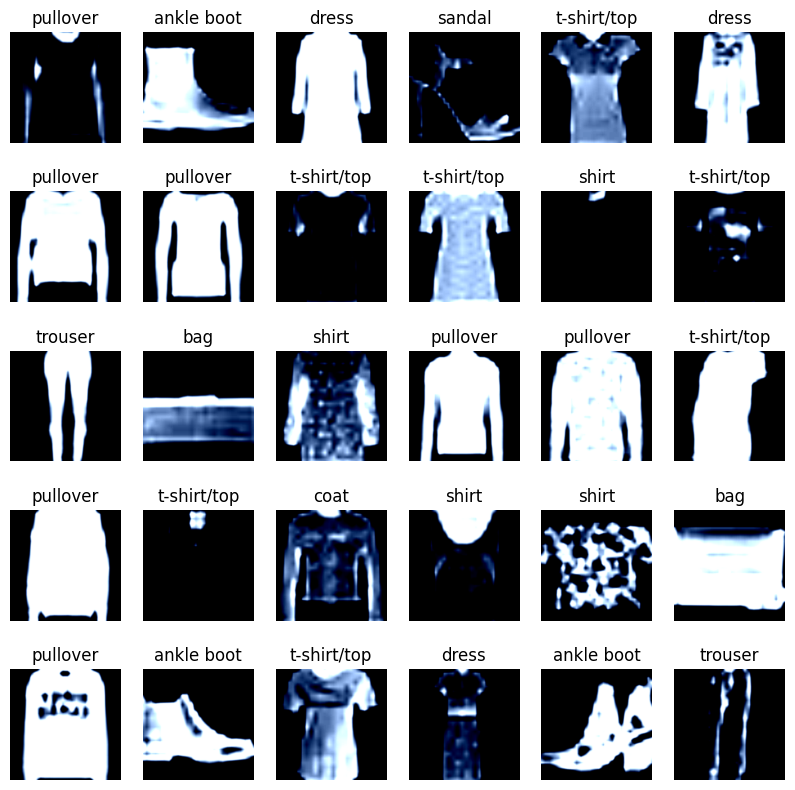

In [22]:
import matplotlib.pyplot as plt

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

In [23]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)
               Grayscale(num_output_channels=3)
               CenterCrop(size=(227, 227))
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [24]:
batch_size = 32 
num_workers = 8 

In [25]:
from torch.utils.data import DataLoader, random_split
train_data = datasets.FashionMNIST(root='data',
                                   train=True,
                                   download=True,
                                   transform=transform)

test_data = datasets.FashionMNIST(root='data',
                                   train=False,
                                   download=True,
                                   transform=transform)

total_len = len(train_data)

test_len = len(test_data)

split_len = total_len // 2

test_split_len = test_len // 2
train_subset, _ = random_split(train_data, [split_len, total_len - split_len])
test_subset, _ = random_split(test_data, [test_split_len, test_len - test_split_len])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
test_loader = DataLoader(test_subset, shuffle=True,num_workers=num_workers)

In [26]:
train_loader

In [27]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.layers = nn.Sequential(
            # input_size=(96, 55, 55)
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(11, 11), stride=4, padding=0),
            nn.ReLU(),
            # input_size=(96, 27, 27)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # input_size=(256, 27, 27)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), stride=1, padding=2),
            nn.ReLU(),
            # input_size=(256, 13, 13)
            nn.MaxPool2d(kernel_size=3, stride=2),
            # input_size=(384, 13, 13)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            # input_size=(384, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            # input_size=(256, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            # input_size=(256, 6, 6)
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256*6*6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=10),
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, 256*6*6)
        x = self.classifier(x)
        return x

In [28]:
import torchsummary

model = AlexNet()
model.to(device)
torchsummary.summary(model, input_size=(3, 227, 227), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

In [29]:
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [30]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    model.train()
    running_size = 0
    running_loss = 0
    corr = 0
    prograss_bar = tqdm(data_loader)
    for batch_idx, (img, lbl) in enumerate(prograss_bar, start=1):
        img, lbl = img.to(device), lbl.to(device)
        optimizer.zero_grad()

        output = model(img)

        loss = loss_fn(output, lbl)

        loss.backward()
        optimizer.step()
        _, pred = output.max(dim=1)
        corr += pred.eq(lbl).sum().item()
        running_loss += loss.item() * img.size(0)
        running_size += img.size(0)
        prograss_bar.set_description(f'[Training] loss: {running_loss / running_size:.4f}, accuracy: {corr / running_size:.4f}')
    acc = corr / len(data_loader.dataset)

    return running_loss / len(data_loader.dataset), acc

In [31]:
def model_evaluate(model, data_loader, loss_fn, device):
    model.eval()
    with torch.no_grad():
        corr = 0
        running_loss = 0
        for img, lbl in data_loader:

            img, lbl = img.to(device), lbl.to(device)

            output = model(img)

            _, pred = output.max(dim=1)

            corr += torch.sum(pred.eq(lbl)).item()

            running_loss += loss_fn(output, lbl).item() * img.size(0)
        acc = corr / len(data_loader.dataset)

        return running_loss / len(data_loader.dataset), acc

In [32]:
min_loss = np.inf
for epoch in range(NUM_EPOCHS):

    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)

    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{MODEL_NAME}.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

[Training] loss: 0.6393, accuracy: 0.7602: 100%|██████████| 938/938 [01:19<00:00, 11.86it/s]


[INFO] val_loss has been improved from inf to 0.46925. Saving Model!
epoch 01, loss: 0.63932, acc: 0.76023, val_loss: 0.46925, val_accuracy: 0.83720


[Training] loss: 0.3844, accuracy: 0.8582: 100%|██████████| 938/938 [01:21<00:00, 11.49it/s]


[INFO] val_loss has been improved from 0.46925 to 0.35782. Saving Model!
epoch 02, loss: 0.38442, acc: 0.85823, val_loss: 0.35782, val_accuracy: 0.87120


[Training] loss: 0.3220, accuracy: 0.8800: 100%|██████████| 938/938 [01:26<00:00, 10.91it/s]


[INFO] val_loss has been improved from 0.35782 to 0.30925. Saving Model!
epoch 03, loss: 0.32199, acc: 0.88003, val_loss: 0.30925, val_accuracy: 0.89360


[Training] loss: 0.2848, accuracy: 0.8945: 100%|██████████| 938/938 [01:20<00:00, 11.59it/s]


epoch 04, loss: 0.28480, acc: 0.89447, val_loss: 0.32177, val_accuracy: 0.88440


[Training] loss: 0.2603, accuracy: 0.9037: 100%|██████████| 938/938 [01:19<00:00, 11.75it/s]


[INFO] val_loss has been improved from 0.30925 to 0.26710. Saving Model!
epoch 05, loss: 0.26031, acc: 0.90370, val_loss: 0.26710, val_accuracy: 0.90260


[Training] loss: 0.2400, accuracy: 0.9102: 100%|██████████| 938/938 [01:21<00:00, 11.51it/s]


epoch 06, loss: 0.24002, acc: 0.91023, val_loss: 0.28157, val_accuracy: 0.89800


[Training] loss: 0.2195, accuracy: 0.9190: 100%|██████████| 938/938 [01:19<00:00, 11.77it/s]


[INFO] val_loss has been improved from 0.26710 to 0.25466. Saving Model!
epoch 07, loss: 0.21946, acc: 0.91903, val_loss: 0.25466, val_accuracy: 0.90760


In [33]:
model.load_state_dict(torch.load(f'{MODEL_NAME}.pth'))

<All keys matched successfully>

In [34]:
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.25391, evaluation accuracy: 0.90540
